In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [5]:
annotation_folder = "/annotations/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
  annotation_zip = tf.keras.utils.get_file("captions.zip",
                                           cache_subdir=os.path.abspath("."),
                                           origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip) + "/annotations/captions_train2014.json"
  os.remove(annotation_zip)

image_folder = "/train2014/"
if not os.path.exists(os.path.abspath(".") + image_folder):
  image_zip = tf.keras.utils.get_file("train2014.zip",
                                      cache_subdir=os.path.abspath("."),
                                      origin="http://images.cocodataset.org/zips/train2014.zip",
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath(".") + image_folder

13510574080/13510573713 [==============================] - 408s 0us/step


In [6]:
with open(annotation_file, "r") as f:
  annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations["annotations"]:
  caption = "<start> " + annot["caption"] + " <end>"
  image_id = annot["image_id"]
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [7]:
len(train_captions), len(all_captions)

(30000, 414113)

In [8]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights="imagenet")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [10]:
!pip install -q tqdm
from tqdm import tqdm

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

1622it [05:43,  4.72it/s]


In [11]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [12]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [13]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [14]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [15]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding="post")

In [16]:
max_length = calc_max_length(train_seqs)

In [17]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [18]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim =  256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

In [20]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode("utf-8")+".npy")
  return img_tensor, cap

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [23]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()

    self.fc = tf.keras.layers.Dense(embedding_dim)
  
  def call(self, x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [24]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)
  
  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)

    x = self.fc1(output)

    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [25]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none")

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [27]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])

  ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
loss_plot = []

In [30]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)

      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [31]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
    batch_loss, t_loss = train_step(img_tensor, target)
    total_loss += t_loss

    if batch % 100 == 0:
      print(f"Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy()/int(target.shape[1]):.4f}")
  
  loss_plot.append(total_loss / num_steps)

  if epoch % 5 == 0:
    ckpt_manager.save()
  
  print(f"Epoch {epoch+1} Loss {total_loss/num_steps:.6f}")

  print(f"Time taken for 1 epoch {time.time() - start} sec\n")

Epoch 1 Batch 0 Loss 2.0122
Epoch 1 Batch 100 Loss 1.1175
Epoch 1 Batch 200 Loss 0.9336
Epoch 1 Batch 300 Loss 0.8315
Epoch 1 Loss 1.040843
Time taken for 1 epoch 394.80004382133484 sec

Epoch 2 Batch 0 Loss 0.8338
Epoch 2 Batch 100 Loss 0.8222
Epoch 2 Batch 200 Loss 0.8021
Epoch 2 Batch 300 Loss 0.7685
Epoch 2 Loss 0.798431
Time taken for 1 epoch 369.51826190948486 sec

Epoch 3 Batch 0 Loss 0.7900
Epoch 3 Batch 100 Loss 0.7690
Epoch 3 Batch 200 Loss 0.7709
Epoch 3 Batch 300 Loss 0.6523
Epoch 3 Loss 0.727380
Time taken for 1 epoch 367.4709749221802 sec

Epoch 4 Batch 0 Loss 0.7049
Epoch 4 Batch 100 Loss 0.6577
Epoch 4 Batch 200 Loss 0.6799
Epoch 4 Batch 300 Loss 0.6251
Epoch 4 Loss 0.681506
Time taken for 1 epoch 366.59199690818787 sec

Epoch 5 Batch 0 Loss 0.6156
Epoch 5 Batch 100 Loss 0.6424
Epoch 5 Batch 200 Loss 0.6193
Epoch 5 Batch 300 Loss 0.6546
Epoch 5 Loss 0.645358
Time taken for 1 epoch 365.92605662345886 sec

Epoch 6 Batch 0 Loss 0.5836
Epoch 6 Batch 100 Loss 0.6321
Epoch 6 

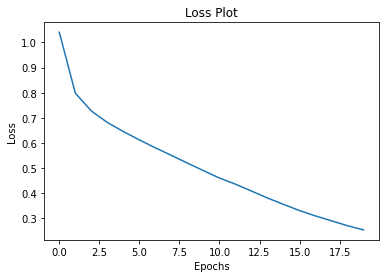

In [32]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()

In [33]:
def evaluate(image):
  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []

  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == "<end>":
      return result, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)
  
  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot

In [34]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(10, 10))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap="gray", alpha=0.6, extent=img.get_extent())
  
  plt.tight_layout()
  plt.show()

Real Caption: <start> an airplane moves through the air with its landing gear extended <end>
Prediction Caption: a small red plane flying over in a field <end>


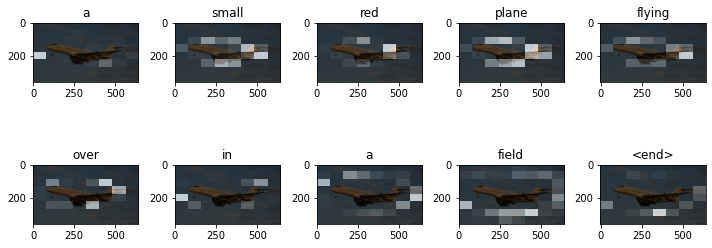

In [35]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: a man riding a surfboard towards <end>


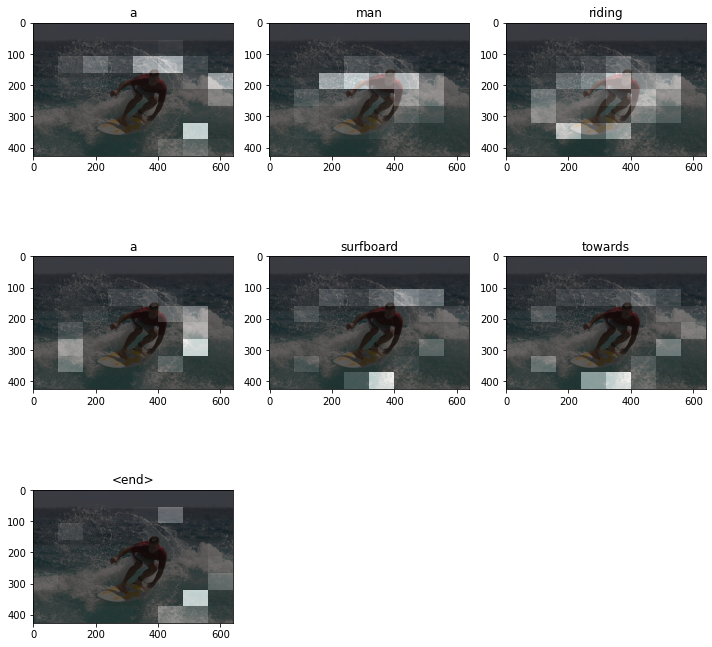

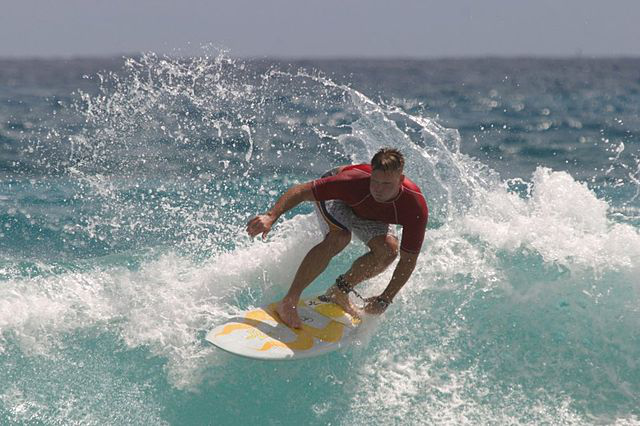

In [36]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

Image.open(image_path)